# COGS 108 - Final Project 

# Overview

In this project, we are going to examine the relationship between the trendiness on Google search engine of several candidates who are currently running for U.S. President 2020 and their fundraising results. For fundraising result of each candidate, we mainly focus on the following three factors: total contribution amount raised, total number of donors and total contribution amount by each census region. By analyzing the trendiness data from GoogleTrends, we wish we can find out how the number of times people search about each candidate online influences the donation he/she obtains from the public.


# Names

- Kartik Bhatnagar
- Kai-Chin Shih 
- Sahana Srinivasan
- (Isaac) Fangzheng Xie 
- (Gin) Xiaojin Zheng 

# Group Members IDs

- A14020665
- A12879790
- A13741839
- A13768347
- A15674894

# Research Question

Are candidates' trendiness on search engines, particularly Google, indicative of fundraising results？
   -Is there a correlation between a candidate’s trendiness on Google and the total contribution amount raised on each day for this candidate?
   -Is there a correlation between a candidate’s trendiness on Google and the total number of unique donors a candidate has?
   -Is there a correlation between a candidate's trendiness on Google and the total contribution amount in each U.S. Census Bureau Region and Division for each candidate?


## Background and Prior Work

The race to become the Democratic Party's frontrunner to take on Trump in 2020 has already begun. More then 25 Democrats have already declared their candidacy for POTUS and have begun campaigning and fundraising. In recent years, campaign funds available to candidates have increasingly determined the way elections pan out. More campaign contributions mean more visibility, more rallies and more opportunties for outreach for candidates, and it can subsquently often be the difference between a win and a loss. 

Social media and online visibility has also played an increasingly important role in a candidate's outreach and momentum. In recent elections, it has completely changed the way candidates interact with their audiences, attract volunteers and gain campaign contributions. Also, with more and more candidates rejecting Super Pac contributions and large donations by corporations, campaign donations by actual voters on a small scale are becoming pivotal to the effectiveness of a candidate's campaign. The volume and distributions of these donations can potentially provide interesting insights into a candidate's viability because it, in a sense, reflects the enthusiasm for the campaign.

In this project, we attempt to more closely examine the correlations between online visibility of a candidate, and the campaign contributions recieved by them. We hope to explore how a candidate's Google search trends relate to the amount of funds raised by them, the number of unique donations they recieve, and the geoographical relationships between their online visibilty and donation rates.

# Hypothesis

Our hypothesis is that the total contributions, total number of unique donors, and total contribution amount by each census region will increase when the candidates’ trendiness rises. In other words, we believe that the correlation between the two will be positive, and that they will be associated. But, we are not claiming that there is causation, or that a candidate's trendiness on Google causes an increase in donations.

The premise of our assumption is that the more people research a candidate, the more interest there is in a candidate, which could be reflected in increased contribution, as contribution is a prime mechanism for expressing interest.


# Dataset(s)

1. Bernie Sanders datasets: <br>
Dataset 1 Name: bernietrend.csv <br>
Link to the dataset: https://trends.google.com/trends/explore?q=%2Fm%2F01_gbv&geo=US <br>
Description: Google search trends for Bernie Sanders<br>
Dataset 2 Name: FEC_Bernie2020.csv <br>
Link to the dataset: https://www.fec.gov/data/receipts/individual-contributions/?two_year_transaction_period=2020&committee_id=C00696948&min_date=01%2F01%2F2019&max_date=12%2F31%2F2020 <br>
Description: Individual FEC contribution records for Bernie Sanders<br><br>
2. Beto O’Rourke datasets: <br>
Dataset 3 Name: betotrend.csv <br>
Link to the dataset: https://trends.google.com/trends/explore?geo=US&q=%2Fm%2F0dty9d <br>
Description: Google search trends for Beto O’Rourke <br>
Dataset 4 Name: FEC_Beto2020.csv <br>
Link to the dataset: https://www.fec.gov/data/receipts/individual-contributions/?two_year_transaction_period=2020&committee_id=C00699090&min_date=01%2F01%2F2019&max_date=12%2F31%2F2020 <br>
Description: Individual FEC contribution records for Beto O’Rourke <br><br>
3. Kamala Harris datasets: <br>
Dataset 5 Name: kamalatrend.csv <br>
Link to the dataset: https://trends.google.com/trends/explore?geo=US&q=%2Fm%2F08sry2 <br>
Description: Google search trends for Kamala Harris <br>
Dataset 6 Name: FEC_Kamala2020.csv <br>
Link to the dataset: https://www.fec.gov/data/receipts/individual-contributions/?two_year_transaction_period=2020&committee_id=C00694455&min_date=01%2F01%2F2019&max_date=12%2F31%2F2020 <br>
Description: Individual FEC contribution records for Kamala Harris

# Setup

In [1]:
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 5)
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

import shapely.geometry as shp

import sklearn.neighbors as skn
import sklearn.metrics as skm

pd.options.display.max_rows = 10

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

# Data Cleaning

### I. To check candidates popularity through Google searches through time

In [3]:
#Bernie Sanders
# Load Google Trends csv file as dataframe
dfBSTrend = pd.read_csv('bernietrend.csv')
# Set column names
dfBSTrend.columns = ['date','trend']
# Change data type from strings to number and date
dfBSTrend['trend'] = dfBSTrend['trend'].apply(pd.to_numeric, errors = 'coerce')
dfBSTrend['date'] = dfBSTrend['date'].astype('datetime64')

#Beto O'Rourke
# Load Google Trends csv file as dataframe
dfBOTrend = pd.read_csv('betotrend.csv')
# Set column names
dfBOTrend.columns = ['date','trend']
# Change data type from strings to number and date
dfBOTrend['trend'] = dfBOTrend['trend'].apply(pd.to_numeric, errors = 'coerce')
dfBOTrend['date'] = dfBOTrend['date'].astype('datetime64')

# Kamala Harris
# Load Google Trends csv file as dataframe
dfKHTrend = pd.read_csv('kamalatrend.csv')
# Set column names
dfKHTrend.columns = ['date','trend']
# Change data type from strings to number and date
dfKHTrend['trend'] = dfKHTrend['trend'].apply(pd.to_numeric, errors = 'coerce')
dfKHTrend['date'] = dfKHTrend['date'].astype('datetime64')

Text(0.5, 1.0, 'Kamala Harris Google Trendiness By Date')

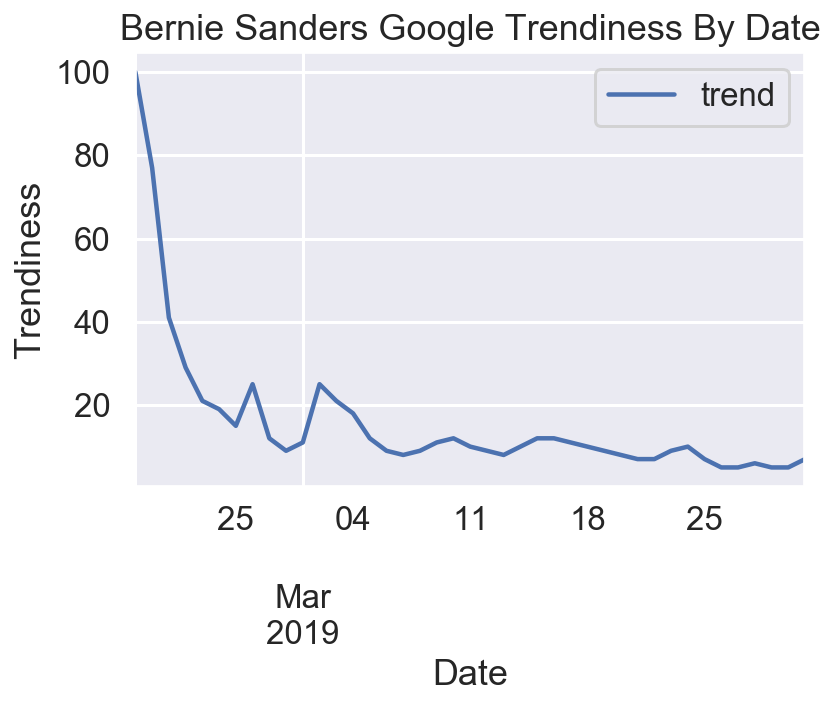

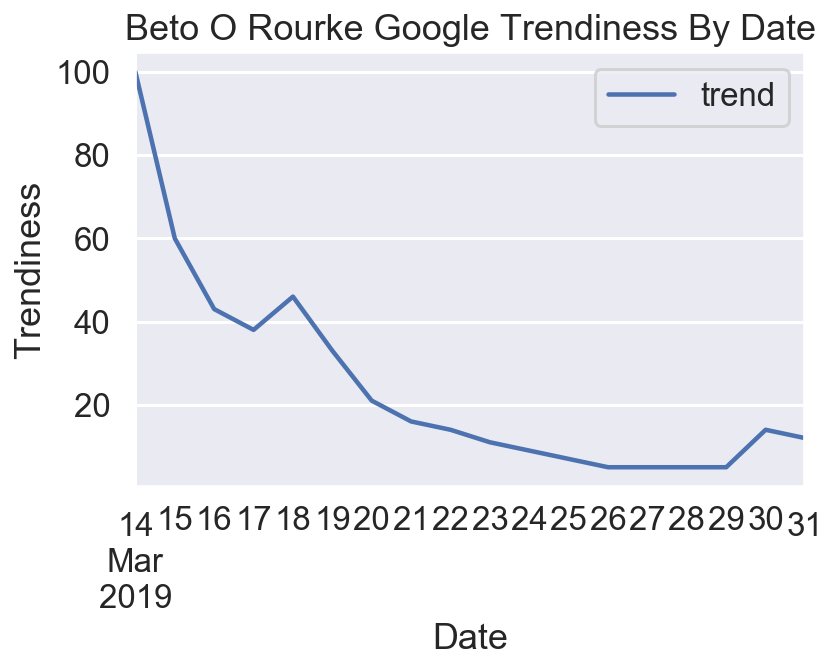

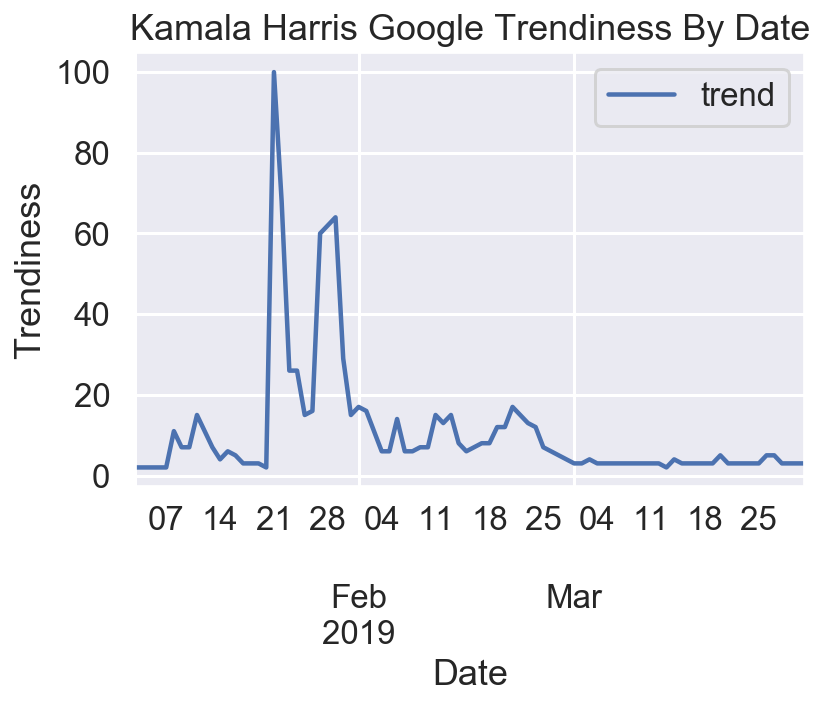

In [4]:
#Bernie Sanders
#Plot the trend and add appropriate axis labels 
bernie = dfBSTrend.plot(x='date', y='trend')
bernie.set_xlabel('Date')
bernie.set_ylabel('Trendiness')
bernie.set_title('Bernie Sanders Google Trendiness By Date')

#Beto O'Rourke
#Plot the trend and add appropriate axis labels
beto = dfBOTrend.plot(x = 'date', y = 'trend')
beto.set_xlabel('Date')
beto.set_ylabel('Trendiness')
beto.set_title('Beto O Rourke Google Trendiness By Date')

# Kamala Harris
#Plot the trend and add appropriate axis labels
kamala = dfKHTrend.plot(x = 'date', y = 'trend') 
kamala.set_xlabel('Date')
kamala.set_ylabel('Trendiness')
kamala.set_title('Kamala Harris Google Trendiness By Date')

### II. To check total donation volume to candidates through FEC data by time trend

In [5]:
#Bernie Sanders
#Load FEC campaign contribution file as dataframe
dfBSFEC = pd.read_csv('FEC_Bernie2020.csv')
# Set column names
dfBSFEC = dfBSFEC[['transaction_id', 'contribution_receipt_date', 'contribution_receipt_amount', 'contributor_state']]
# Change data type from string to date or numeric form
dfBSFEC['contribution_receipt_date'] = dfBSFEC['contribution_receipt_date'].astype("datetime64")
dfBSFEC['contribution_receipt_amount'] = dfBSFEC['contribution_receipt_amount'].apply(pd.to_numeric)

#Beto O'Rourke
#Load FEC campaign contribution file as dataframe
dfBOFEC = pd.read_csv('FEC_Beto2020.csv')
# Set column names
dfBOFEC = dfBOFEC[['transaction_id', 'contribution_receipt_date', 'contribution_receipt_amount', 'contributor_state']]
# Change data type from string to date or numeric form
dfBOFEC['contribution_receipt_date'] = dfBOFEC['contribution_receipt_date'].astype("datetime64")
dfBOFEC['contribution_receipt_amount'] = dfBOFEC['contribution_receipt_amount'].apply(pd.to_numeric)

#Kamala Harris
#Load FEC campaign contribution file as dataframe
dfKHFEC = pd.read_csv('FEC_Kamala2020.csv')
# Set column names
dfKHFEC = dfKHFEC[['transaction_id', 'contribution_receipt_date', 'contribution_receipt_amount', 'contributor_state']]
# Change data type from string to date or numeric form
dfKHFEC['contribution_receipt_date'] = dfKHFEC['contribution_receipt_date'].astype("datetime64")
dfKHFEC['contribution_receipt_amount'] = dfKHFEC['contribution_receipt_amount'].apply(pd.to_numeric)

/Users/Sahana/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Sahana/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (35,36,37,38,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Sahana/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (35,36,37,38,39,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.0, 'Total Contribution Amount By Date to Harris')

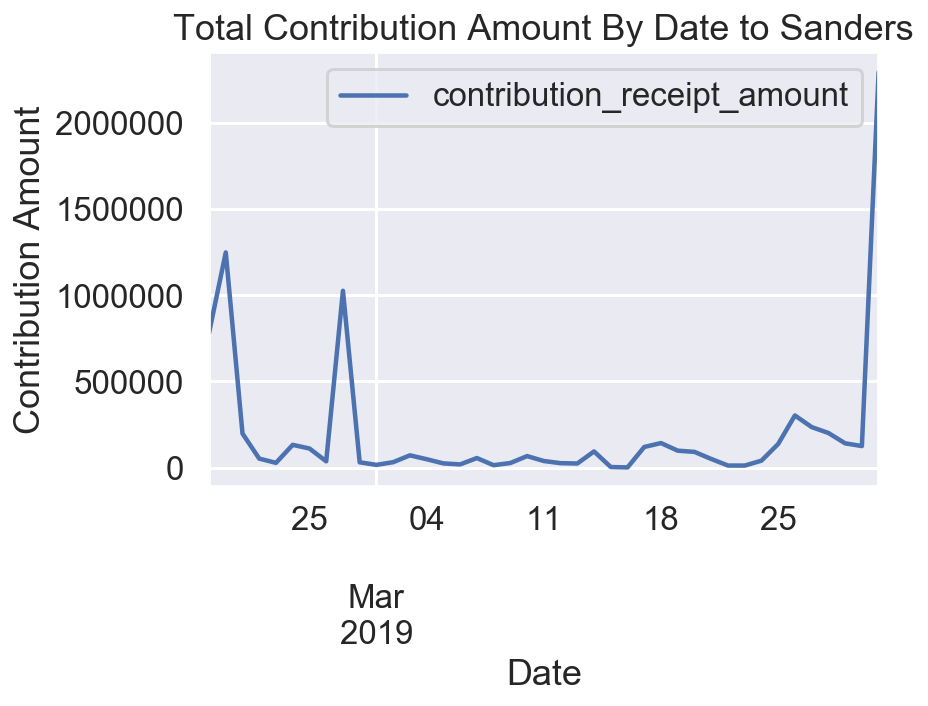

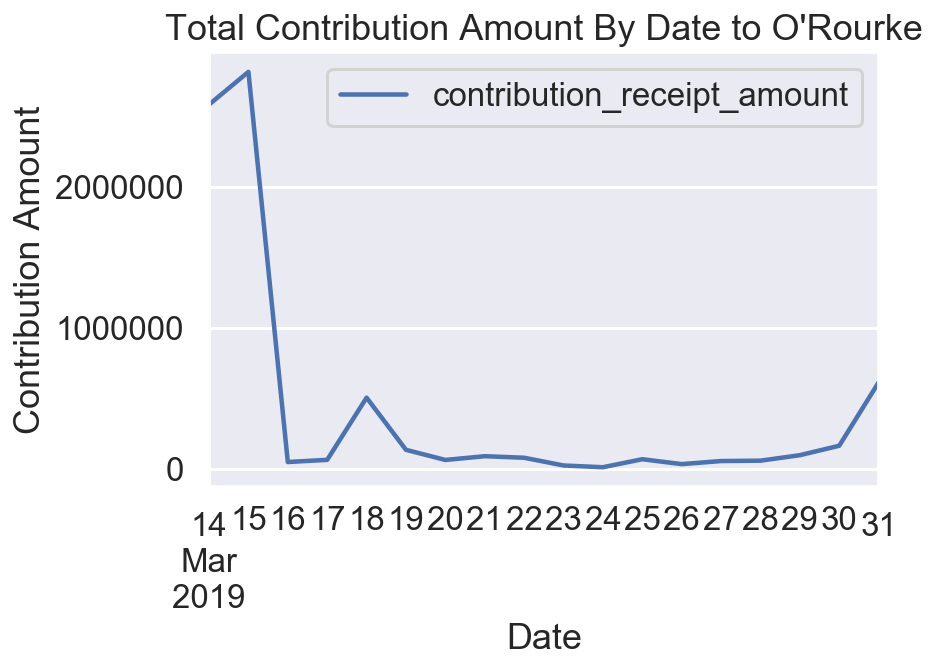

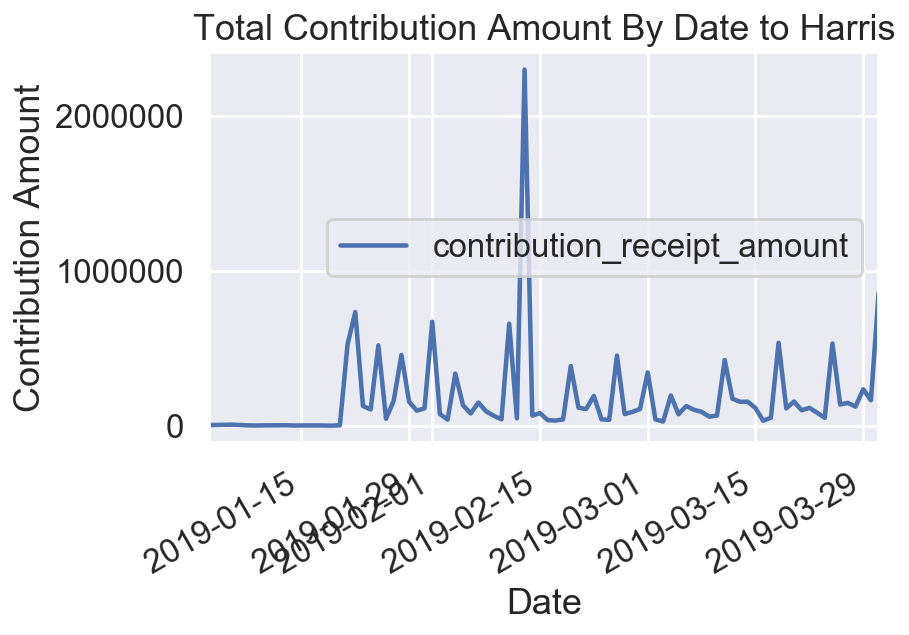

In [6]:
# Bernie Sanders
# Create pivot table to obtain total amount raised for each day
dfBSAmount = pd.pivot_table(dfBSFEC, index=['contribution_receipt_date'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name as date
dfBSAmount.index.names = ['date']
# Plot Bernie daily contribution amounts
bernie2 = dfBSAmount.plot()
# Set graph appearance
bernie2.set_xlabel('Date')
bernie2.set_ylabel('Contribution Amount')
bernie2.set_title('Total Contribution Amount By Date to Sanders')

# Beto O'Rourke
# Create pivot table to obtain total amount raised for each day
dfBOAmount = pd.pivot_table(dfBOFEC, index = ['contribution_receipt_date'], values = ["contribution_receipt_amount"], aggfunc = np.sum)
# Set column name as date
dfBOAmount.index.names = ['date']
# Plot Beto daily contribution amounts
beto2 = dfBOAmount.plot() 
# Set graph appearance
beto2.set_xlabel('Date')
beto2.set_ylabel('Contribution Amount')
beto2.set_title('Total Contribution Amount By Date to O\'Rourke')

# Kamala Harris
# Create pivot table to obtain total amount raised for each day
dfKHAmount = pd.pivot_table(dfKHFEC, index = ['contribution_receipt_date'], values = ["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name as date
dfKHAmount.index.names = ['date']
# Plot Kamala daily contribution amounts
kamala2 = dfKHAmount.plot()
# Set graph appearance
kamala2.set_xlabel('Date')
kamala2.set_ylabel('Contribution Amount')
kamala2.set_title('Total Contribution Amount By Date to Harris')

### III. To check total donation actions to candidates through FEC data by time trend

Text(0.5, 1.0, 'Total Transactions By Date to Harris')

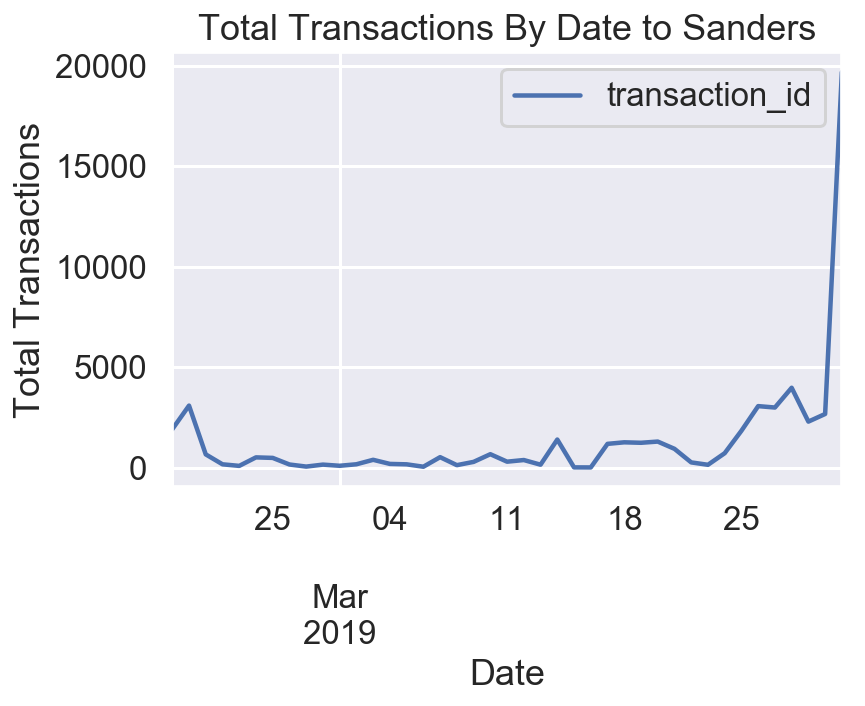

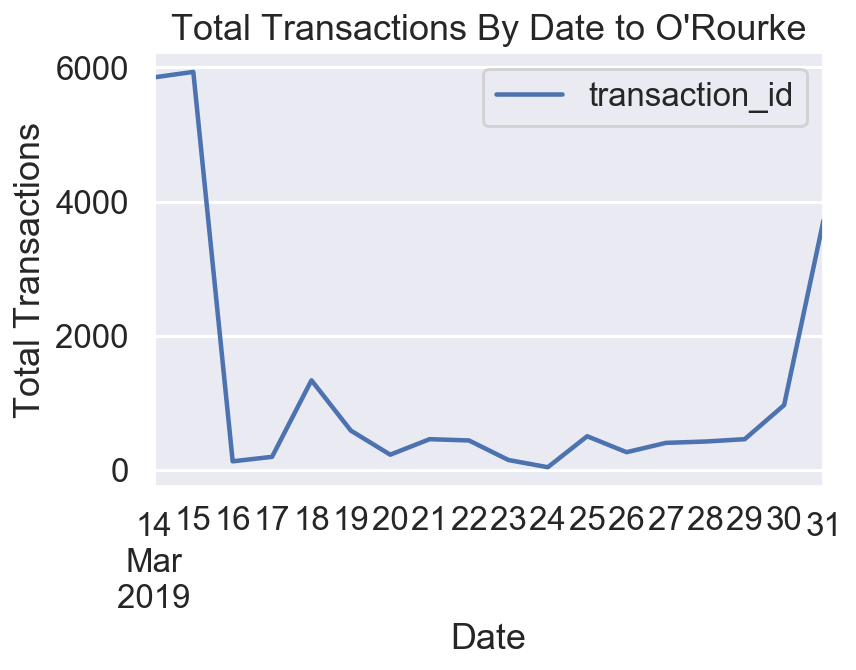

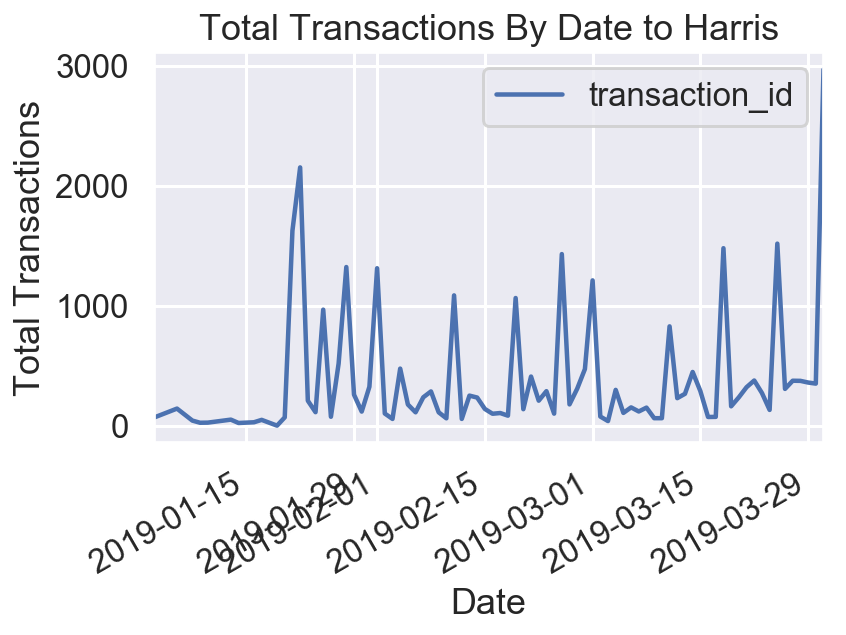

In [7]:
# Bernie Sanders
# Create pivot table to obtain total number of transactions each day
dfBSDonors = pd.pivot_table(dfBSFEC, index=["contribution_receipt_date"],values=["transaction_id"], aggfunc=lambda x: len(x.unique()))
# Set column name
dfBSDonors.index.names = ['date']
# Plot total number of transactions
bernie3 = dfBSDonors.plot()
# Set graph appearance
bernie3.set_xlabel('Date')
bernie3.set_ylabel('Total Transactions')
bernie3.set_title('Total Transactions By Date to Sanders')

# Beto O'Rourke
# Create pivot table to obtain total number of transactions each day
dfBODonors = pd.pivot_table(dfBOFEC, index=["contribution_receipt_date"],values=["transaction_id"], aggfunc=lambda x: len(x.unique()))
# Set column name
dfBODonors.index.names = ['date']
# Plot total number of transactions
beto3 = dfBODonors.plot()
# Set graph appearance
beto3.set_xlabel('Date')
beto3.set_ylabel('Total Transactions')
beto3.set_title('Total Transactions By Date to O\'Rourke')

# Kamala Harris
# Create pivot table to obtain total number of transactions each day
dfKHDonors = pd.pivot_table(dfKHFEC, index=["contribution_receipt_date"],values=["transaction_id"], aggfunc=lambda x: len(x.unique()))
# Set column name
dfKHDonors.index.names = ['date']
# Plot total number of transactions
kamala3 = dfKHDonors.plot()
# Set graph appearance
kamala3.set_xlabel('Date')
kamala3.set_ylabel('Total Transactions')
kamala3.set_title('Total Transactions By Date to Harris')

### IV. To check candidates popularity through google searching trend by state

In [8]:
# Bernie Sanders
# Create pivot table to obtain total amount raised by state
dfBSStates = pd.pivot_table(dfBSFEC, index=['contributor_state'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name
dfBSStates.index.names = ['state']

# Beto O'Rourke
# Create pivot table to obtain total amount raised by state
dfBOStates = pd.pivot_table(dfBOFEC, index=['contributor_state'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name
dfBOStates.index.names = ['state']

# Kamala Harris
# Create pivot table to obtain total amount raised by state
dfKHStates = pd.pivot_table(dfKHFEC, index=['contributor_state'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name
dfKHStates.index.names = ['state']

In [9]:
# Bernie Sanders
# Load Google Trends by state file into dataframe
dfBSTrendStates = pd.read_csv('bernietrend_state.csv')
# Set column names
dfBSTrendStates.columns = ['state','trend']
# Change data type to numeric
dfBSTrendStates['trend'] = dfBSTrendStates['trend'].apply(pd.to_numeric, errors = 'coerce')

# Beto O'Rourke
# Load Google Trends by state file into dataframe
dfBOTrendStates = pd.read_csv('betotrend_state.csv')
# Set column names
dfBOTrendStates.columns = ['state','trend']
# Change data type to numeric
dfBOTrendStates['trend'] = dfBOTrendStates['trend'].apply(pd.to_numeric, errors = 'coerce')

# Kamala Harris
# Load Google Trends by state file into dataframe
dfKHTrendStates = pd.read_csv('kamalatrend_state.csv')
# Set column names
dfKHTrendStates.columns = ['state','trend']
# Change data type to numeric
dfKHTrendStates['trend'] = dfKHTrendStates['trend'].apply(pd.to_numeric, errors = 'coerce')

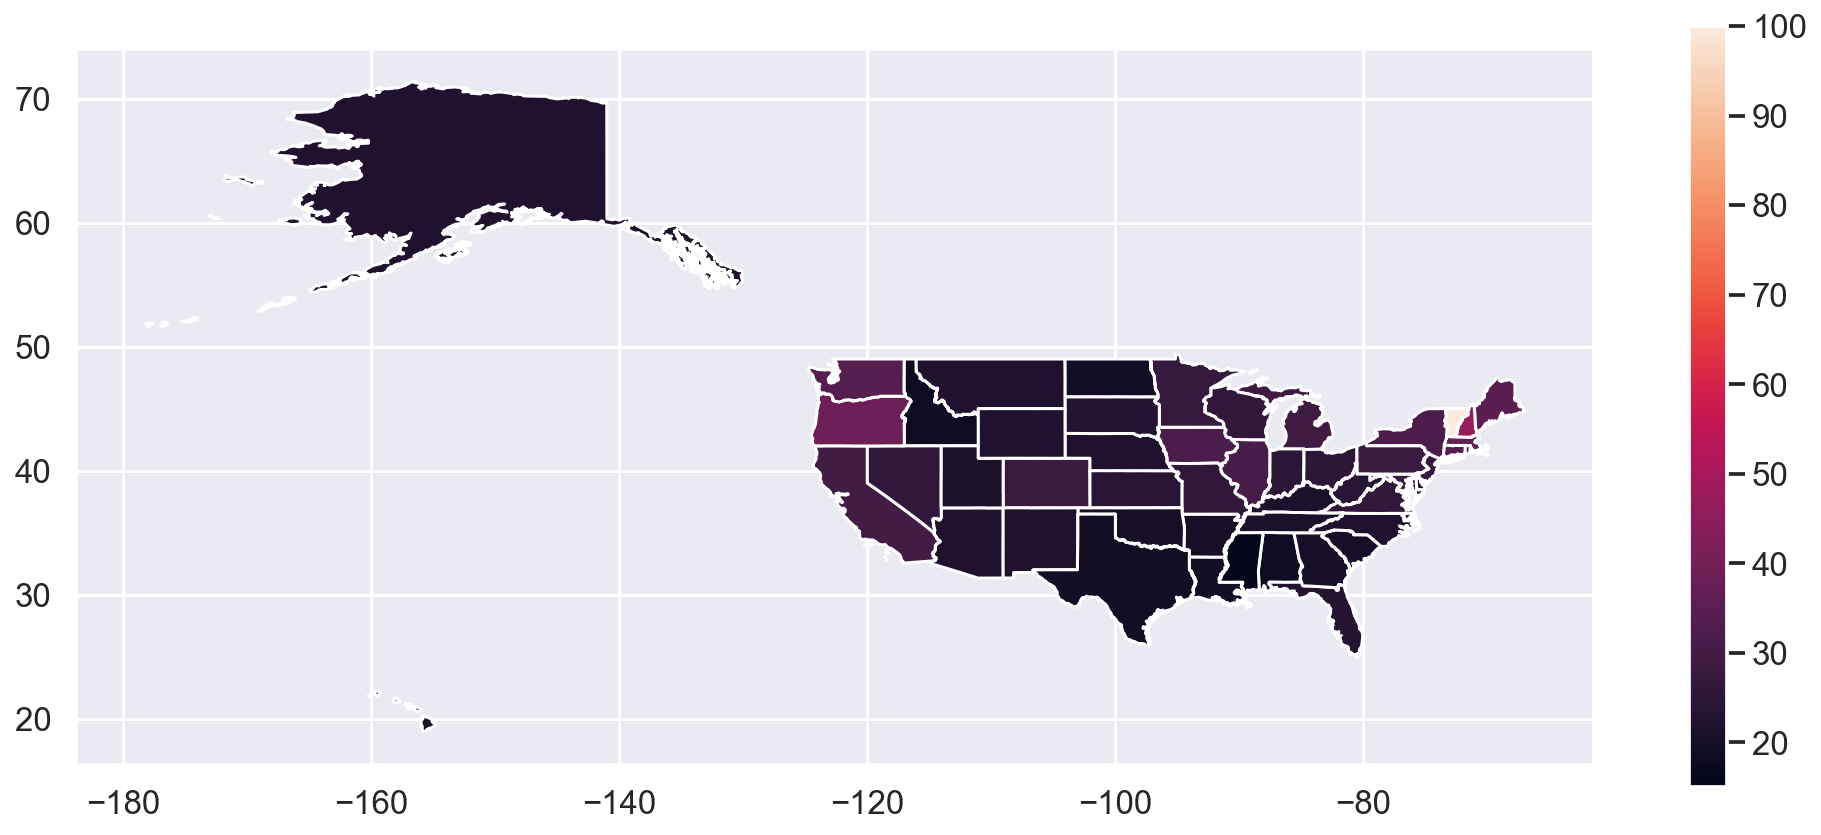

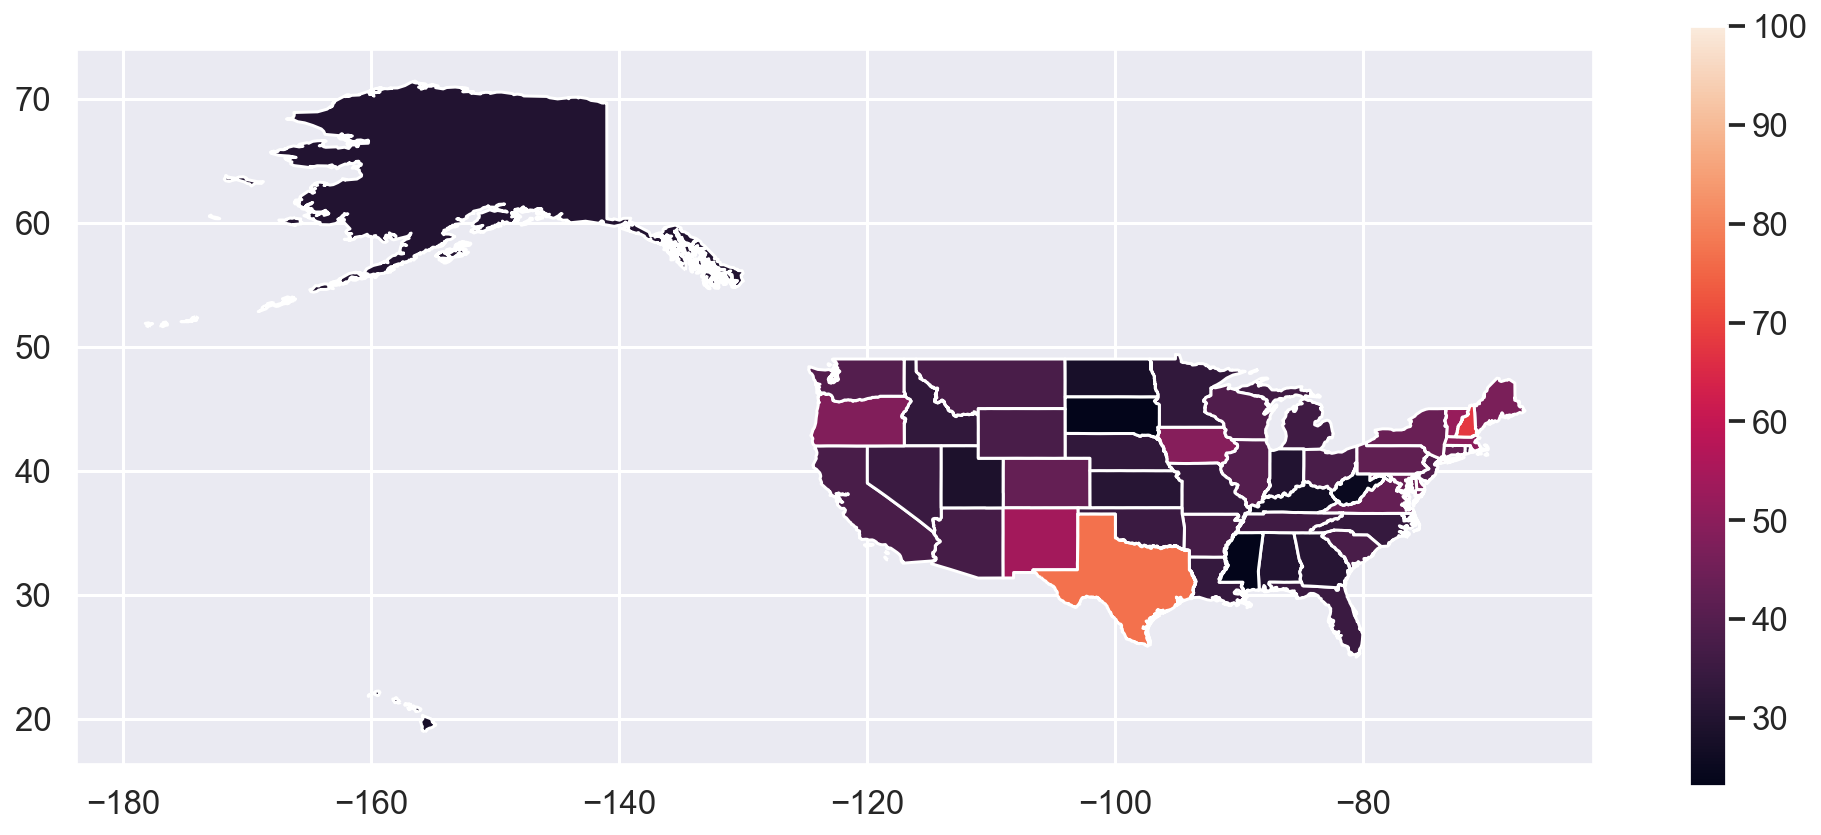

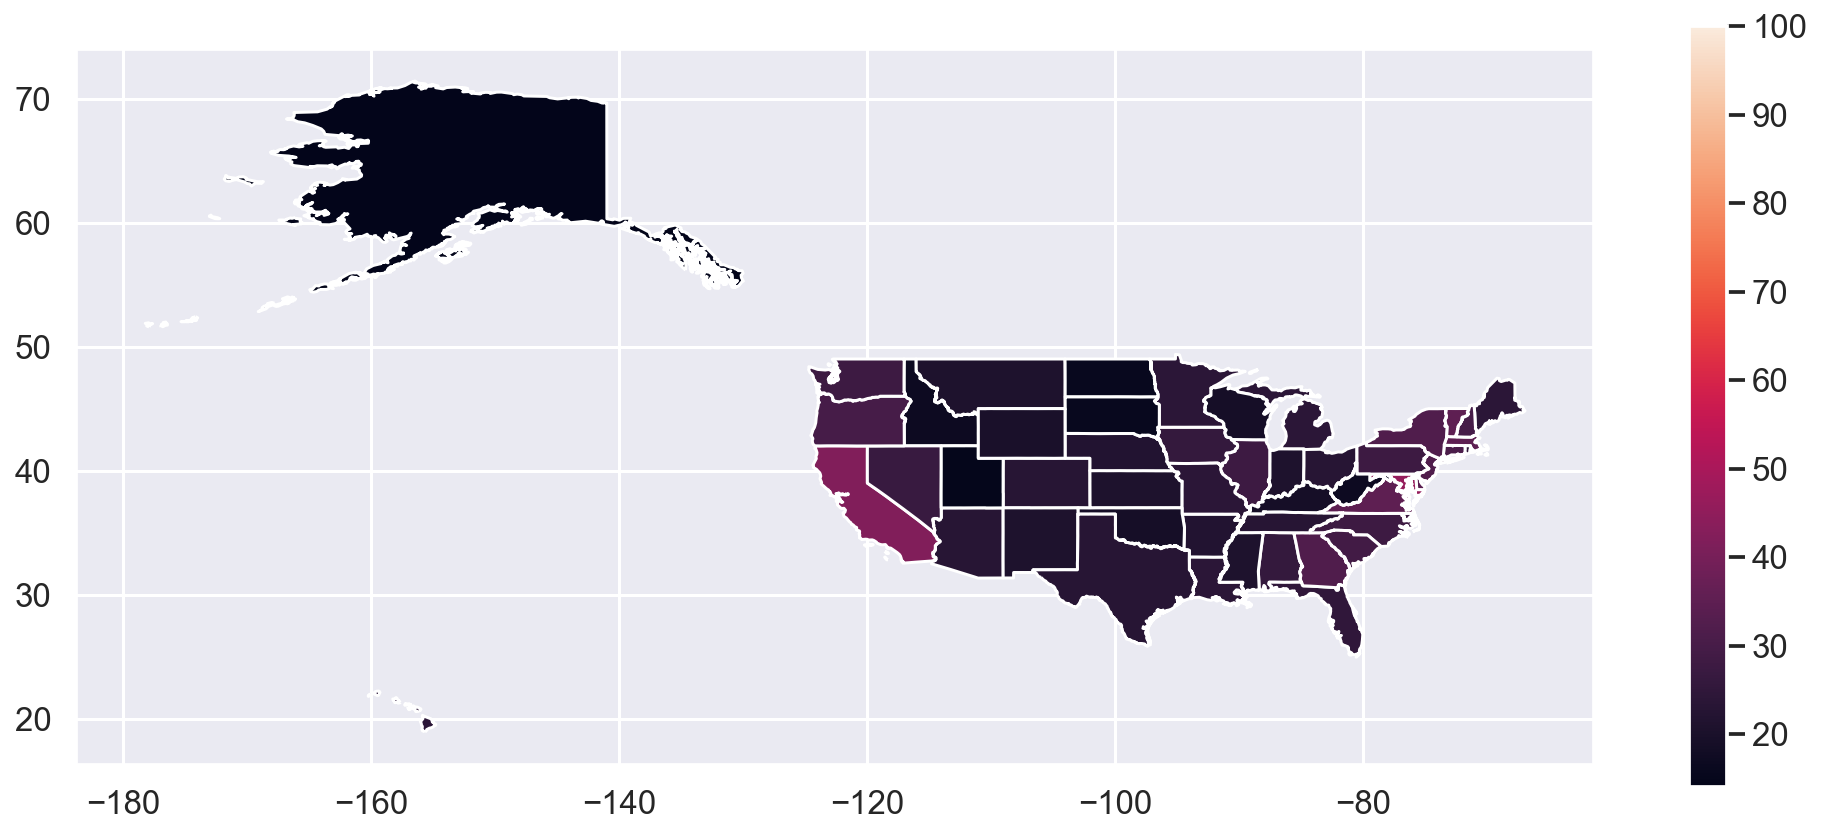

In [10]:
# Loading shape data for mapping
usa = gpd.read_file('./states_21basic/states.shp')
usa = usa.sort_values(by=['STATE_NAME'])

# Bernie Sanders
# Plot Bernie popularity by state onto US map
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=dfBSTrendStates['trend'],ax=ax, legend=True);

# Beto O'Rourke
# Plot Beto popularity by state onto US map
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=dfBOTrendStates['trend'],ax=ax, legend=True);

# Kamala Harris
# Plot Kamala popularity by state onto US map
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=dfKHTrendStates['trend'],ax=ax, legend=True);

# Data Analysis & Results

### I. Correlation between popularity over time and daily total donation amounts

#### Visualization

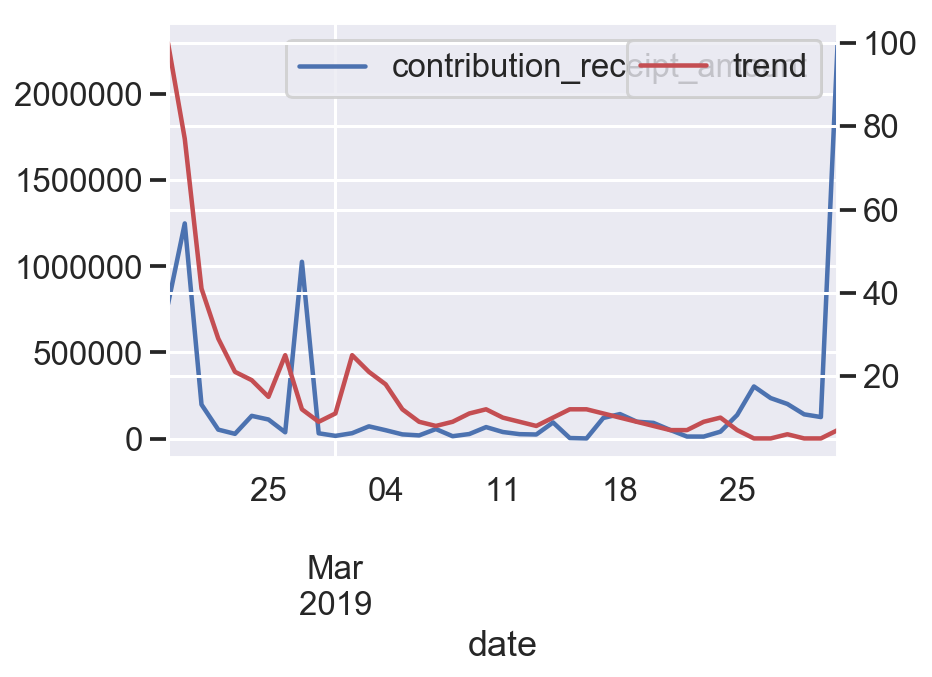

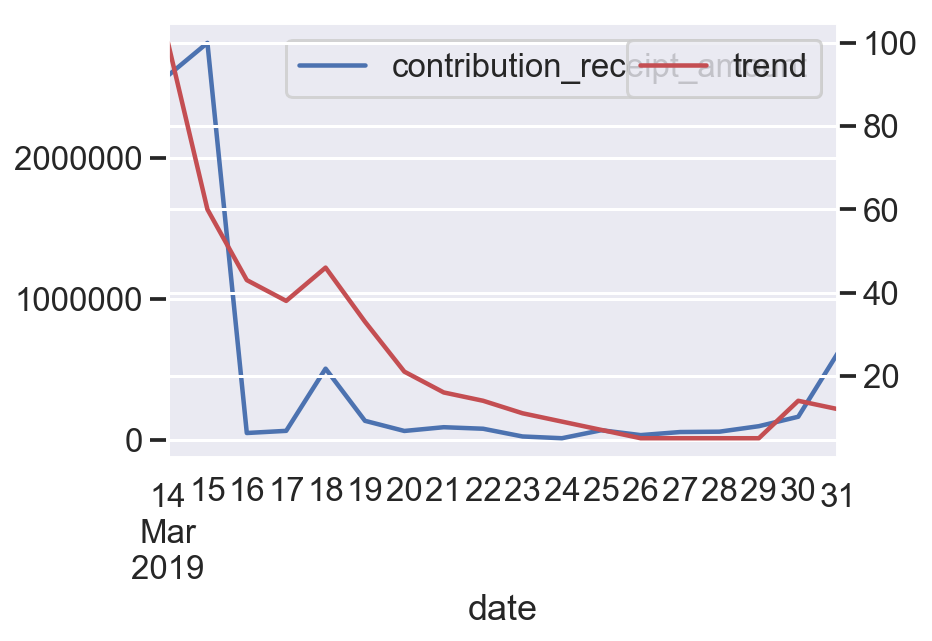

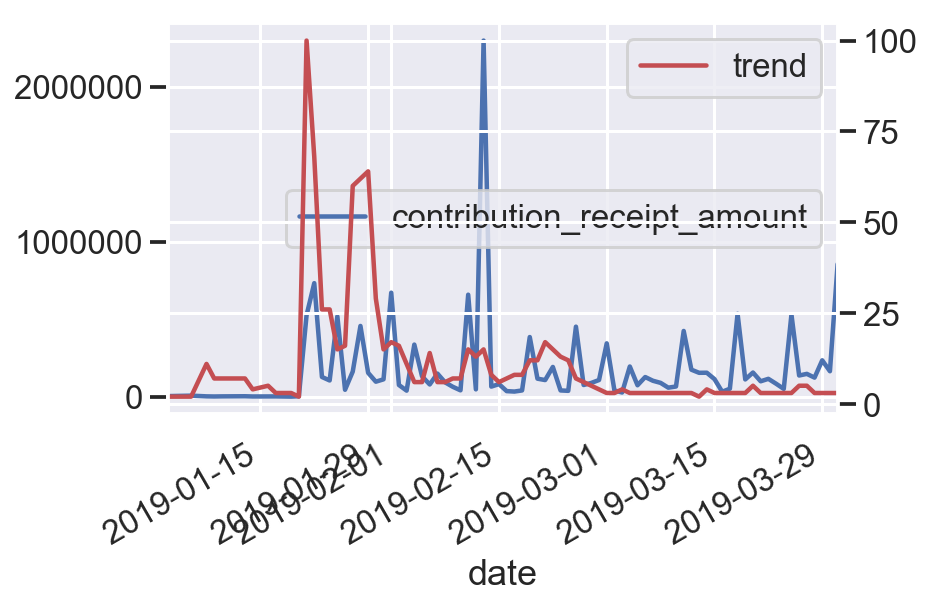

In [11]:
# Bernie Sanders
# Visually analyze correlation between Google Trends figures and total amount raised
# Merge dataframes on date
BSMerged = (pd.merge(dfBSAmount, dfBSTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
BSMerged = BSMerged.dropna()
# Plot trends and amount
ax = BSMerged.plot('date','contribution_receipt_amount')
ax1 = ax.twinx()
BSMerged.plot('date','trend',ax=ax1, color='r')

# Beto O'Rourke
# Visually analyze correlation between Google Trends figures and total amount raised
# Merge dataframes on date
BOMerged = (pd.merge(dfBOAmount, dfBOTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
BOMerged = BOMerged.dropna()
# Plot trends and amount
ax = BOMerged.plot('date','contribution_receipt_amount')
ax1 = ax.twinx()
BOMerged.plot('date','trend',ax=ax1, color='r')

# Kamala Harris
# Visually analyze correlation between Google Trends figures and total amount raised
# Merge dataframes on date
KHMerged = (pd.merge(dfKHAmount, dfKHTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
KHMerged = KHMerged.dropna()
# Plot trends and amount
ax = KHMerged.plot('date','contribution_receipt_amount')
ax1 = ax.twinx()
KHMerged.plot('date','trend',ax=ax1, color='r')

#### Regression analysis

In [12]:
# Bernie Sanders
# Analyze correlation between Google Trends figures and total amount raised
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", BSMerged)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.114
Model:                                     OLS   Adj. R-squared:                  0.091
Method:                          Least Squares   F-statistic:                     5.022
Date:                         Wed, 05 Jun 2019   Prob (F-statistic):             0.0308
Time:                                 14:41:42   Log-Likelihood:                -586.67
No. Observations:                           41   AIC:                             1177.
Df Residuals:                               39   BIC:                             1181.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

##### The result shows that the correlation of the trendiness of the candidate and the total contribution to each candidate is statistically significant at the p = 0.05 level. This means that, given the null hypothesis is true that there is no correlation between trendiness and total contribution, there is only a 3.1% percent change we would observe this sample. So, for every one unit increase in trendiness, there is an approximately $7,840.78 increase in total campaign contribution.

In [13]:
# Beto O'Rourke
# Analyze correlation between Google Trends figures and total amount raised
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", BOMerged)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.642
Model:                                     OLS   Adj. R-squared:                  0.620
Method:                          Least Squares   F-statistic:                     28.72
Date:                         Wed, 05 Jun 2019   Prob (F-statistic):           6.39e-05
Time:                                 14:41:42   Log-Likelihood:                -261.47
No. Observations:                           18   AIC:                             526.9
Df Residuals:                               16   BIC:                             528.7
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/Sahana/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


##### The result shows that in the Beto O'Rourke's case, the the Google trend statistically correlates with total amount raised since the coef is not zero and P value is 0.

In [14]:
# Kamala Harris
# Analyze correlation between Google Trends figures and total amount raised
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", KHMerged)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.058
Model:                                     OLS   Adj. R-squared:                  0.046
Method:                          Least Squares   F-statistic:                     4.844
Date:                         Wed, 05 Jun 2019   Prob (F-statistic):             0.0307
Time:                                 14:41:42   Log-Likelihood:                -1134.3
No. Observations:                           81   AIC:                             2273.
Df Residuals:                               79   BIC:                             2277.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

##### The result shows that in the Kamala Harris's case, the the Google trend statistically correlates with total amount raised since the coef is not zero and P value is smaller than 0.05.

### II. Correlation between popularity over time and daily total number of transactions

#### Visualization

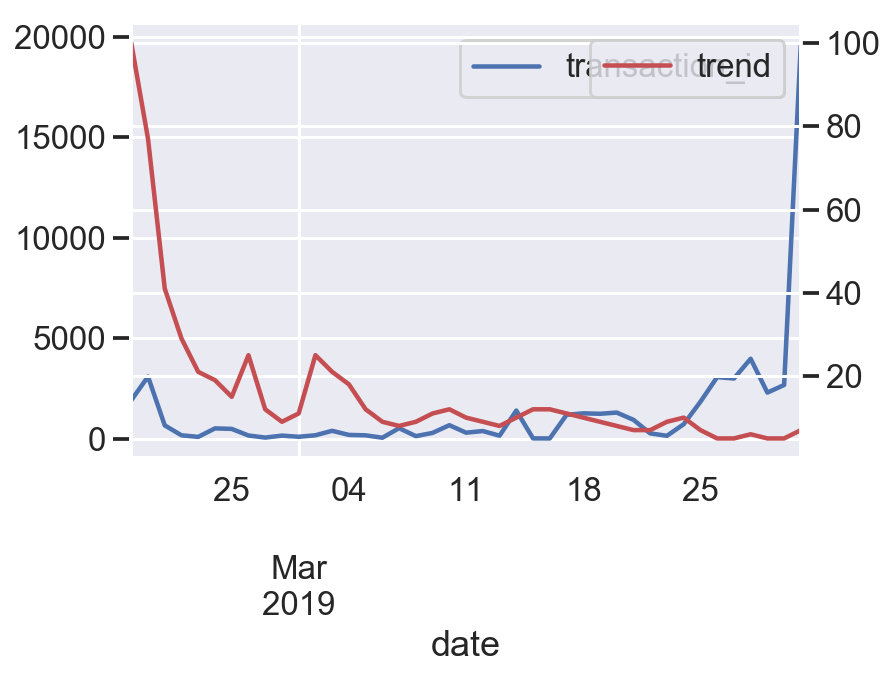

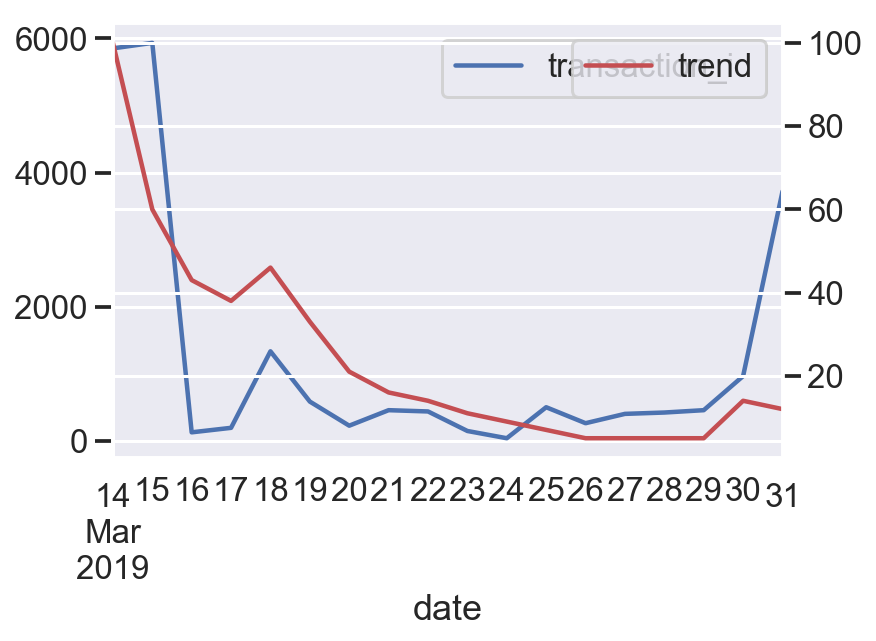

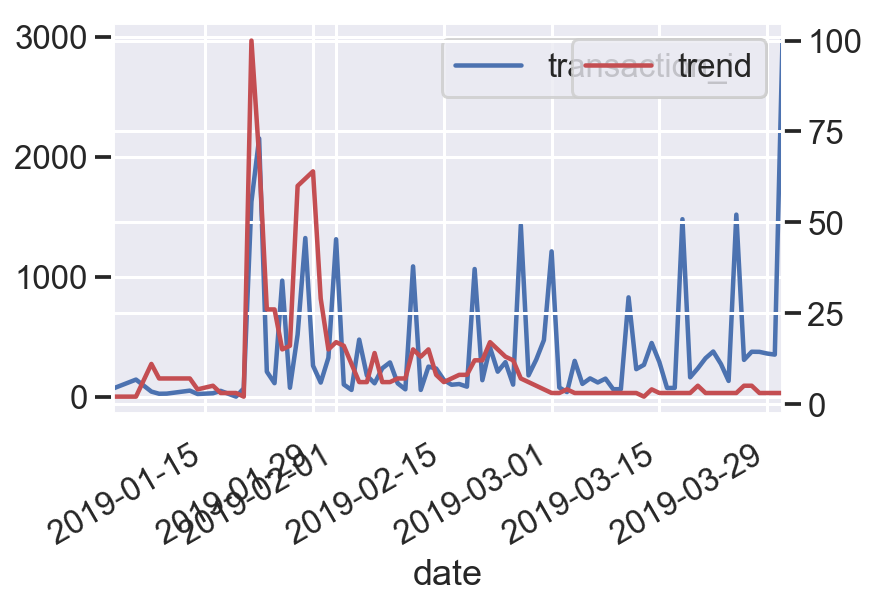

In [15]:
# Bernie Sanders
# Visually analyze correlation between Google Trends figures and total number of transactions each day
# Merge dataframes on date
BSMerged2 = (pd.merge(dfBSDonors, dfBSTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
BSMerged2 = BSMerged2.dropna()
# Plot trends and counts
ax = BSMerged2.plot('date','transaction_id')
ax1 = ax.twinx()
BSMerged2.plot('date','trend',ax=ax1, color='r')


# Beto O'Rourke
# Visually analyze correlation between Google Trends figures and total number of transactions each day
# Merge dataframes on date
BOMerged2 = (pd.merge(dfBODonors, dfBOTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
BOMerged2 = BOMerged2.dropna()
# Plot trends and counts
ax = BOMerged2.plot('date','transaction_id')
ax1 = ax.twinx()
BOMerged2.plot('date','trend',ax=ax1, color='r')

# Kamala Harris
# Visually analyze correlation between Google Trends figures and total number of transactions each day
# Merge dataframes on date
KHMerged2 = (pd.merge(dfKHDonors, dfKHTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
KHMerged2 = KHMerged2.dropna()
# Plot trends and counts
ax = KHMerged2.plot('date','transaction_id')
ax1 = ax.twinx()
KHMerged2.plot('date','trend',ax=ax1, color='r')

#### Regression Analysis

In [16]:
# Bernie Sanders
# Analyze correlation between Google Trends figures and total number of transactions each day
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("transaction_id~trend", BSMerged2)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:         transaction_id   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                   0.02265
Date:                Wed, 05 Jun 2019   Prob (F-statistic):              0.881
Time:                        14:41:43   Log-Likelihood:                -387.36
No. Observations:                  41   AIC:                             778.7
Df Residuals:                      39   BIC:                             782.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1426.3240    655.198      2.177      0.0

##### Based on the OLS Regression Results, Google Trends is not statistically siginificant to total number of transactions each day since P value is much larger than 0.05.

In [17]:
# Beto O'Rourke
# Analyze correlation between Google Trends figures and total number of transactions each day
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("transaction_id~trend", BOMerged2)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:         transaction_id   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     17.10
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           0.000777
Time:                        14:41:43   Log-Likelihood:                -154.27
No. Observations:                  18   AIC:                             312.5
Df Residuals:                      16   BIC:                             314.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -103.4215    453.411     -0.228      0.8

/Users/Sahana/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


##### In Beto O'Rourke's case, the Google trends is statistically correlated to total number of transactions each day, since the coef is not zero and P value smaller than 0.05.

In [18]:
# Kamala Harris
# Analyze correlation between Google Trends figures and total number of transactions each day
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("transaction_id~trend", KHMerged2)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:         transaction_id   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     12.48
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           0.000690
Time:                        14:41:44   Log-Likelihood:                -616.98
No. Observations:                  81   AIC:                             1238.
Df Residuals:                      79   BIC:                             1243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    257.5300     66.713      3.860      0.0

##### In Kamala Harris's case, the Google trends is statistically correlated to total number of transactions each day, since the coef is not zero and P value smaller than 0.05.

### III. Correlation between popularity and total funds raised to-date by state

#### Visualization on trend

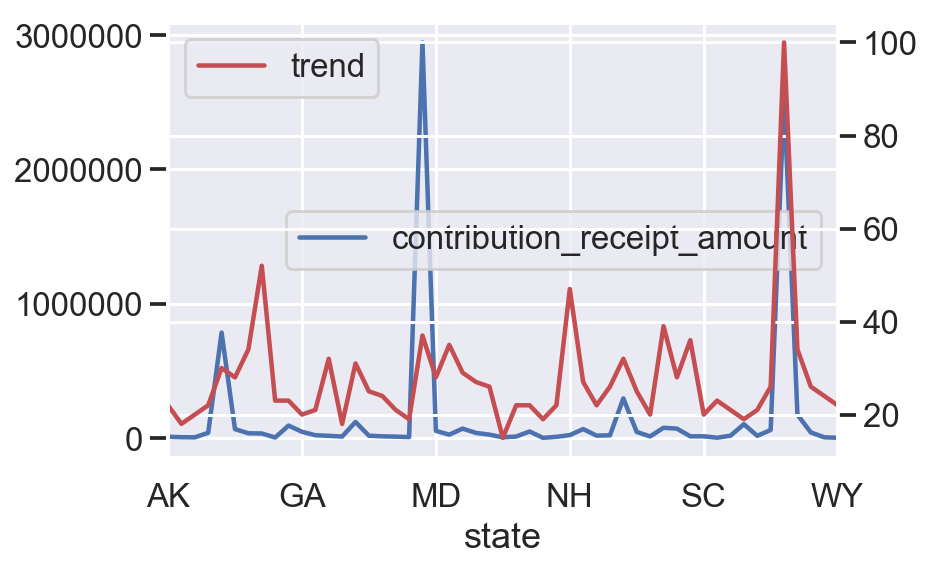

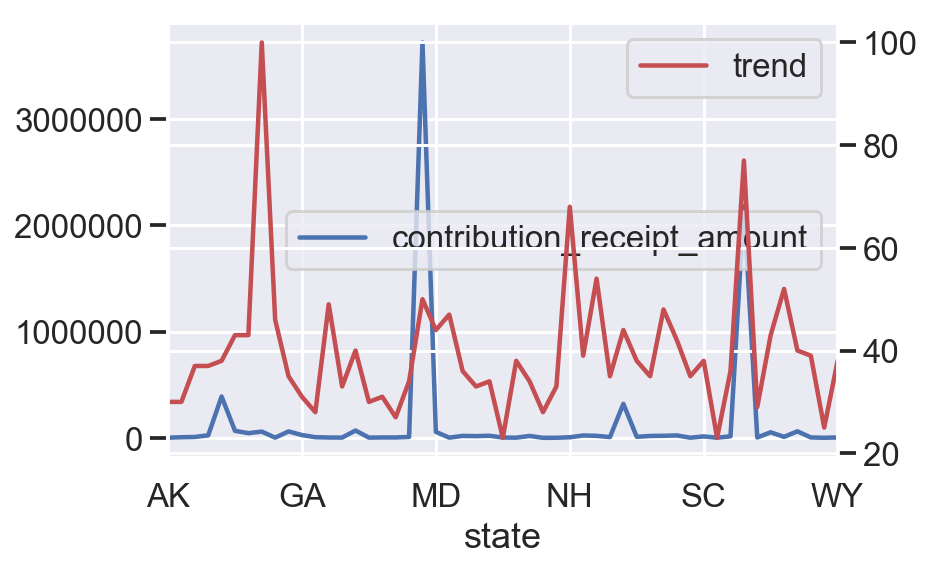

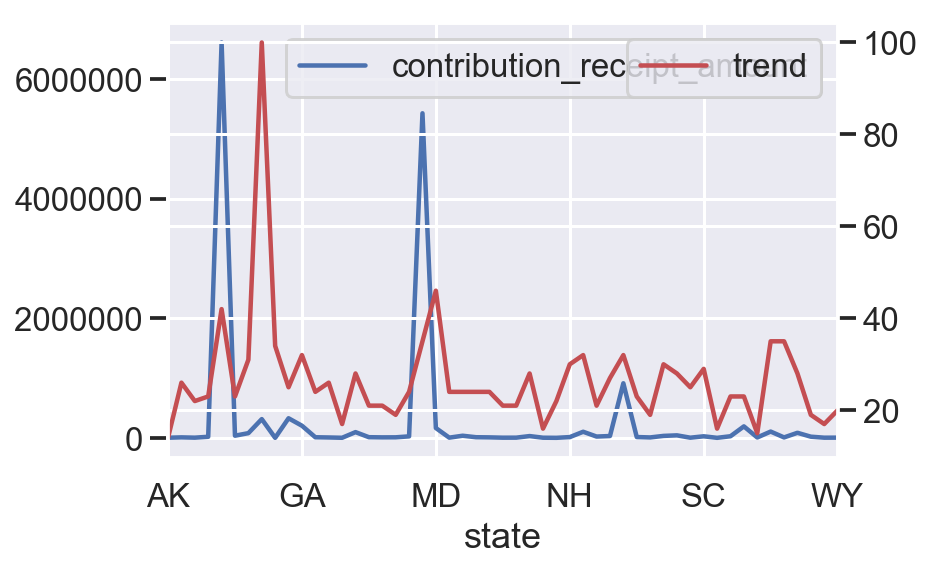

In [19]:
# Bernie Sanders
# Visually analyze correlation between Google Trends figures and total amount raised by states 
# Merge dataframes on state
BSMerged3 = (pd.merge(dfBSStates, dfBSTrendStates, how='outer', on='state'))
# Drop all states when either fundraising amount was missing or trend data was missing
BSMerged3 = BSMerged3.dropna()
# Plot trends and amount
ax = BSMerged3.plot('state','contribution_receipt_amount')
ax1 = ax.twinx()
BSMerged3.plot('state','trend',ax=ax1, color='r')


# Beto O'Rourke
# Visually analyze correlation between Google Trends figures and total amount raised by states 
# Merge dataframes on state
BOMerged3 = (pd.merge(dfBOStates, dfBOTrendStates, how='outer', on='state'))
# Drop all states when either fundraising amount was missing or trend data was missing
BOMerged3 = BOMerged3.dropna()
# Plot trends and amount
ax = BOMerged3.plot('state','contribution_receipt_amount')
ax1 = ax.twinx()
BOMerged3.plot('state','trend',ax=ax1, color='r')

# Kamala Harris
# Visually analyze correlation between Google Trends figures and total amount raised by states 
# Merge dataframes on state
KHMerged3 = (pd.merge(dfKHStates, dfKHTrendStates, how='outer', on='state'))
# Drop all states when either fundraising amount was missing or trend data was missing
KHMerged3 = KHMerged3.dropna()
# Plot trends and amount
ax = KHMerged3.plot('state','contribution_receipt_amount')
ax1 = ax.twinx()
KHMerged3.plot('state','trend',ax=ax1, color='r')

#### Regression Analysis

In [20]:
# Bernie Sanders
# Analyze correlation between Google Trends figures and total amount raised by states
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", BSMerged3)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.398
Model:                                     OLS   Adj. R-squared:                  0.386
Method:                          Least Squares   F-statistic:                     32.42
Date:                         Wed, 05 Jun 2019   Prob (F-statistic):           6.92e-07
Time:                                 14:41:45   Log-Likelihood:                -732.16
No. Observations:                           51   AIC:                             1468.
Df Residuals:                               49   BIC:                             1472.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

##### In Bernie Sander's case, the Google trends is statistically correlated to the total amount raised by states, since the coef is not zero and P value smaller than 0.05.

In [21]:
# Beto O'Rourke
# Analyze correlation between Google Trends figures and total amount raised by states
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", BOMerged3)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.100
Model:                                     OLS   Adj. R-squared:                  0.081
Method:                          Least Squares   F-statistic:                     5.424
Date:                         Wed, 05 Jun 2019   Prob (F-statistic):             0.0240
Time:                                 14:41:45   Log-Likelihood:                -747.42
No. Observations:                           51   AIC:                             1499.
Df Residuals:                               49   BIC:                             1503.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

##### In Beto O'Rourke's case, the Google trends is statistically correlated to the total amount raised by states, since the coef is not zero and P value smaller than 0.05.

In [22]:
# Kamala Harris
# Analyze correlation between Google Trends figures and total amount raised by states
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", KHMerged3)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.059
Model:                                     OLS   Adj. R-squared:                  0.040
Method:                          Least Squares   F-statistic:                     3.066
Date:                         Wed, 05 Jun 2019   Prob (F-statistic):             0.0862
Time:                                 14:41:45   Log-Likelihood:                -783.47
No. Observations:                           51   AIC:                             1571.
Df Residuals:                               49   BIC:                             1575.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

##### In Kamala Harris's case, the Google Trends is not statistically significant to total amount riased by states since P value is relatively large. 

#### Visualization on map

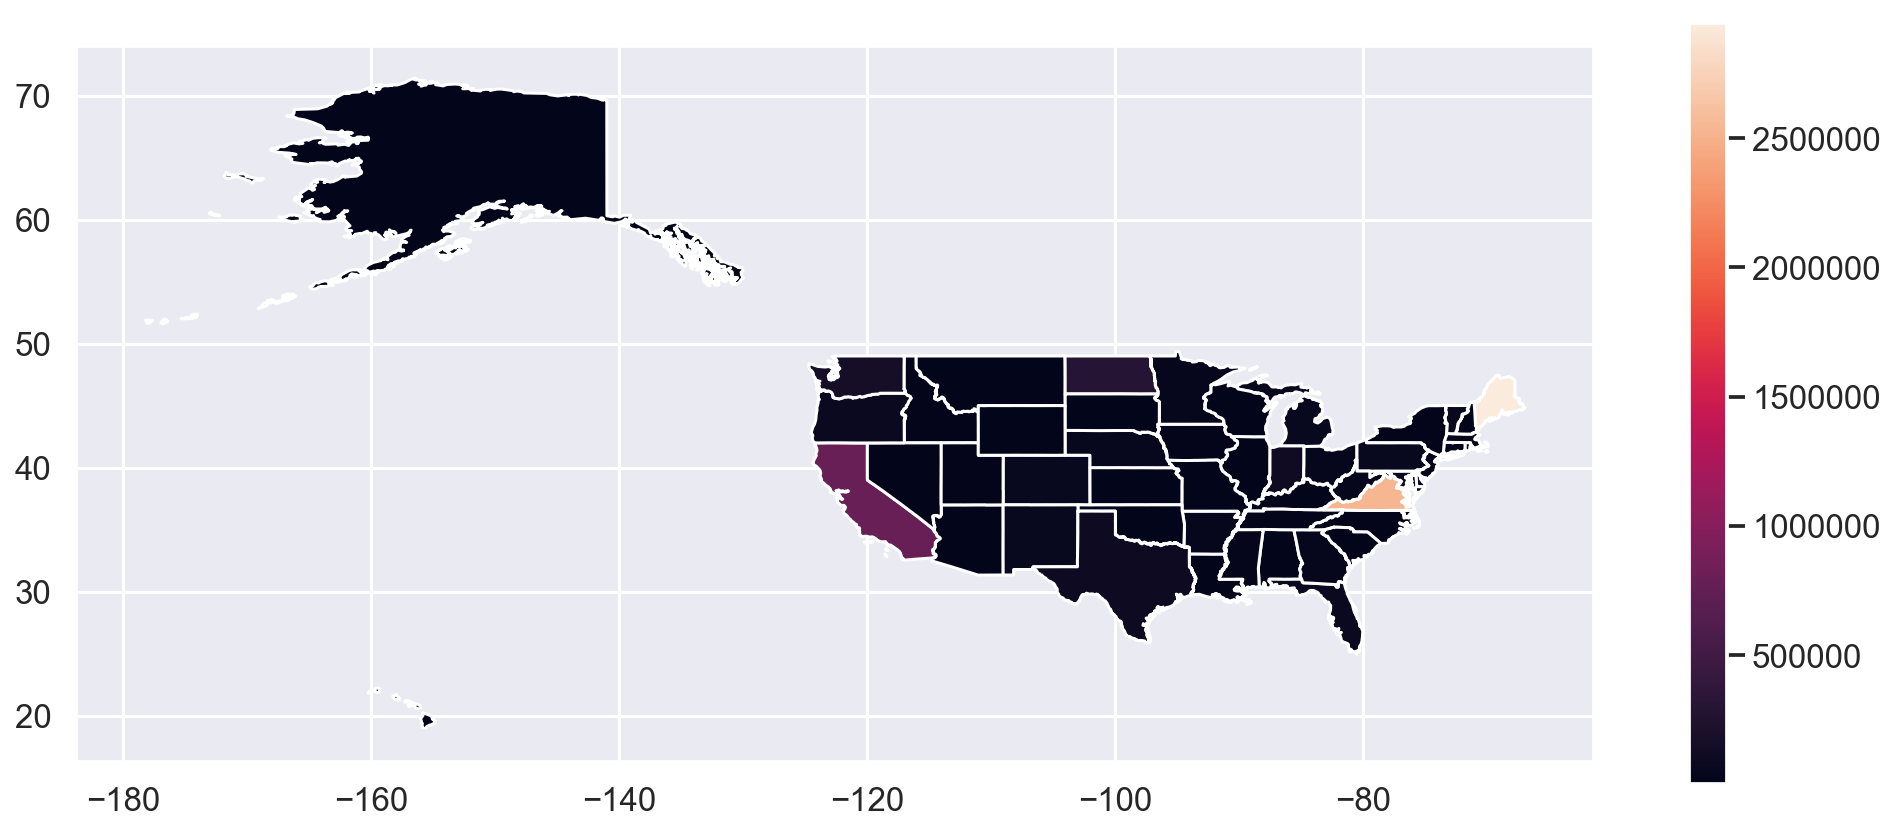

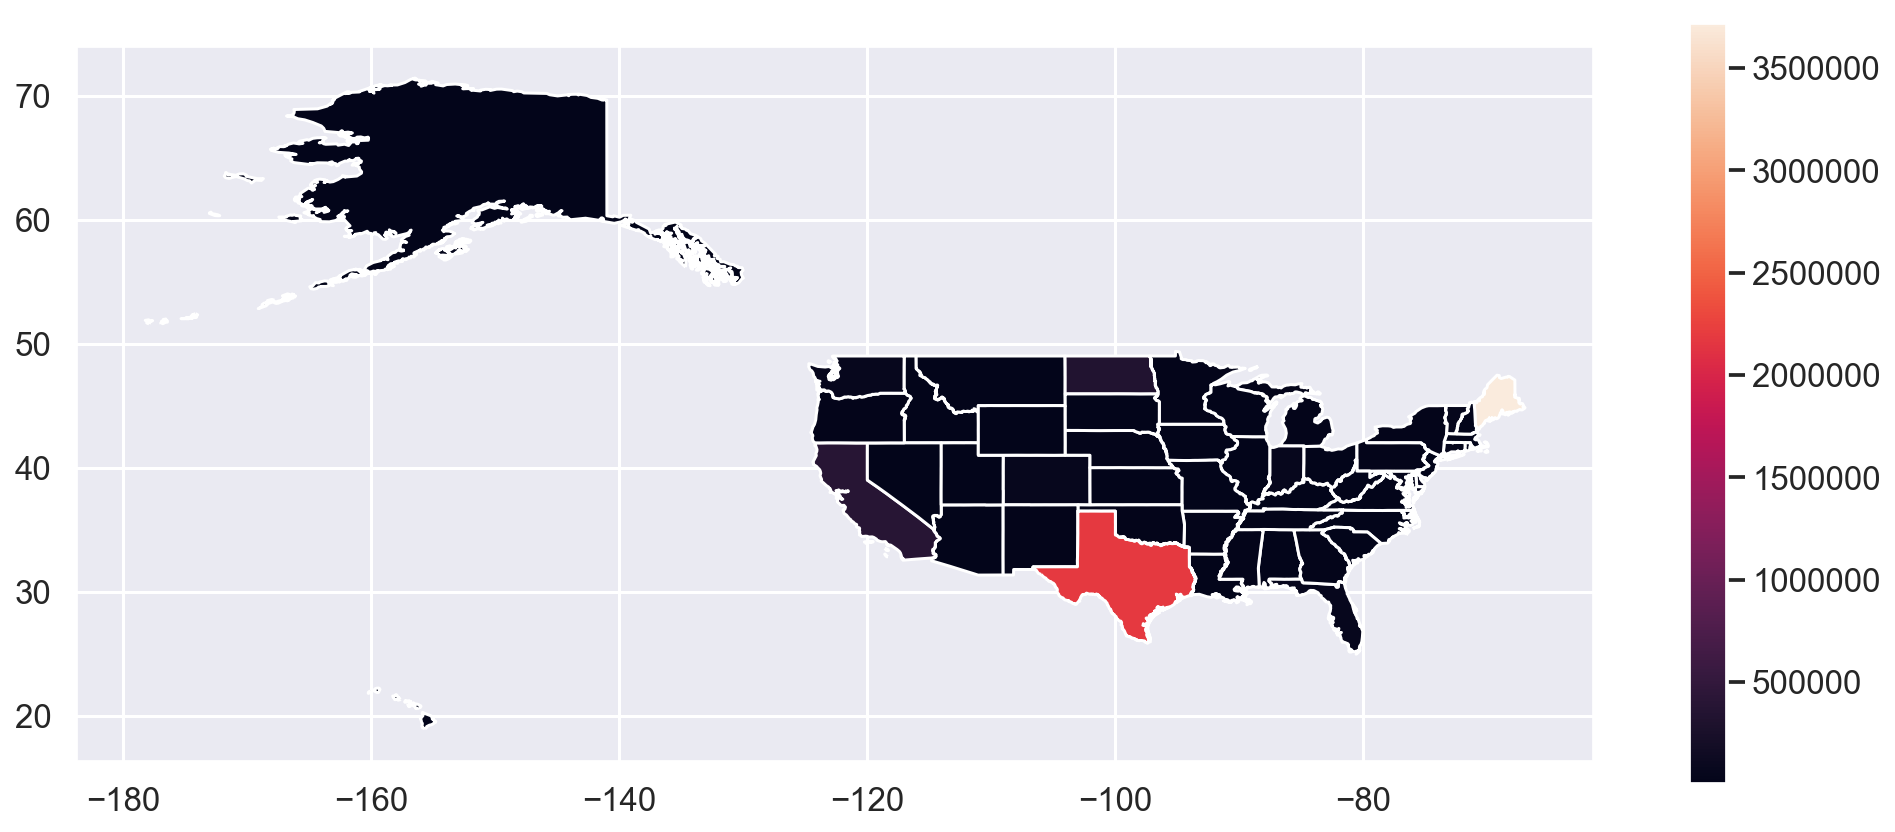

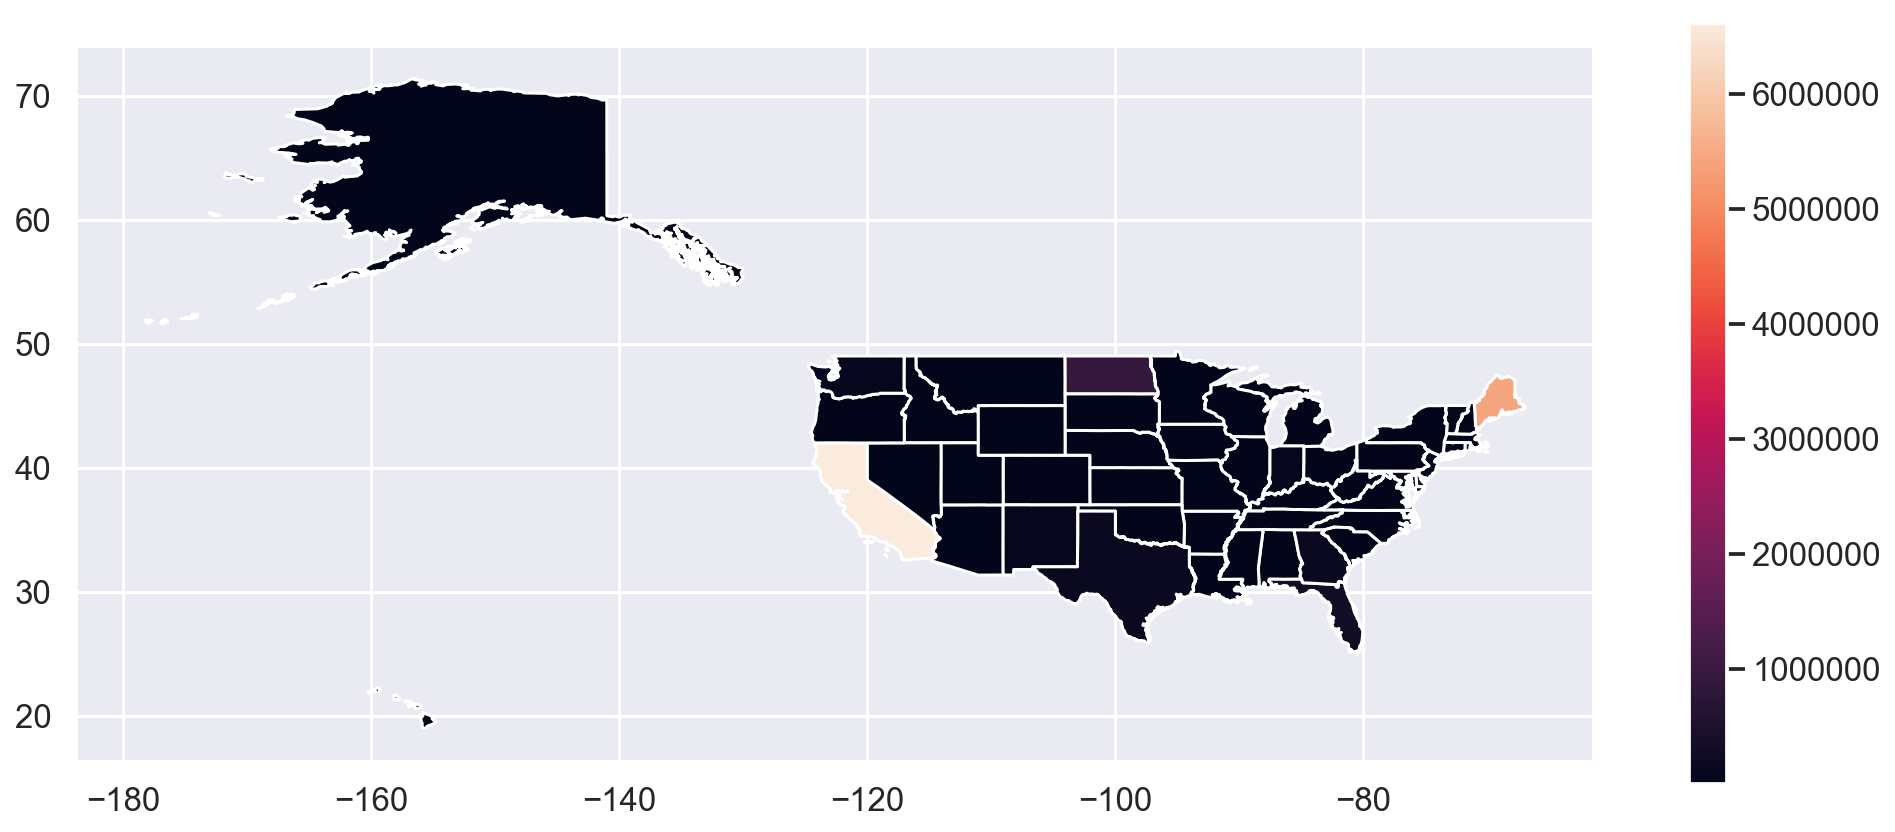

In [23]:
# Bernie Sanders
# Color each state based on total funds raised
usa = usa.sort_values(by=['STATE_NAME'])
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=BSMerged3['contribution_receipt_amount'],ax=ax, legend=True);

# Beto O'Rourke
# Color each state based on total funds raised
usa = usa.sort_values(by=['STATE_NAME'])
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=BOMerged3['contribution_receipt_amount'],ax=ax, legend=True);

# Kamala Harris
# Color each state based on total funds raised
usa = usa.sort_values(by=['STATE_NAME'])
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=KHMerged3['contribution_receipt_amount'],ax=ax, legend=True);

# Ethics & Privacy

Our data collection process itself was not affected by ethical dilemmas because both the Census data and campaign contribution amounts were publically available. Our Google trends data is slightly biased in that the popularity rankings given to us per candidate are all relative; the exact number of Google searches per region or per state is not provided to us. Instead, the ranking simply shows us where a candidate experiences hsi highest popularity, and then Thus, there is likely a slight skew in how the data is presented. The FEC (Federal Election Commission) data is not subject to this bias because the quantitative values are definitive and accurate. Furthermore, our analyses are also subject to error because,

# Conclusion & Discussion

*Fill in your discussion information here*